In [1]:
import numpy as np
import pandas as pd
import torch

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

In [2]:
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [3]:
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(78,64),
            nn.ReLU(True),
            nn.Linear(64,32),
            nn.ReLU(True),
            nn.Linear(32,latent_dim*2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim,32),
            nn.ReLU(True),
            nn.Linear(32,64),
            nn.ReLU(True),
            nn.Linear(64,78)
        )
    
    def encode(self, x):
        mean_logvar = self.encoder(x)
        mean, log_var = torch.chunk(mean_logvar, 2, dim=1)
        return mean, log_var
    
    def reparaterize(self, mean, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return mean + eps*std
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        mean, log_var = self.encode(x)
        z = self.reparaterize(mean, log_var)
        return self.decode(z), mean, log_var

In [4]:
# VAE loss function
def vae_loss(x, x_recon, mean, log_var):
    recon_loss = nn.MSELoss()(x_recon, x)
    kl_loss = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return recon_loss + kl_loss

In [5]:
# Data loading
audio_mixed_noratio_data = pd.read_csv('/Users/jiachenyao/Desktop/Thesis/Preprocessed_data/mix_emo_audio_no_time_noratio.csv')
audio_single_data = pd.read_csv('/Users/jiachenyao/Desktop/Thesis/Preprocessed_data/single_emo_audio_no_time.csv')

In [6]:
# get labels
audio_mixed_noratio_string_labels = audio_mixed_noratio_data.iloc[:, 0].values
audio_single_string_labels = audio_single_data.iloc[:, 0].values

# get data
audio_mixed_noratio_data = audio_mixed_noratio_data.iloc[:, 1:].values
audio_single_data = audio_single_data.iloc[:, 1:].values


In [7]:
label_encoder = LabelEncoder()

# encode labels
audio_mixed_noratio_numerical_labels = label_encoder.fit_transform(audio_mixed_noratio_string_labels)
audio_single_numerical_labels = label_encoder.fit_transform(audio_single_string_labels)

# storing the mapping information
mix_label_mapping = dict(zip(audio_mixed_noratio_numerical_labels, audio_mixed_noratio_string_labels))
single_label_mapping = dict(zip(audio_single_numerical_labels, audio_single_string_labels))

# train test split
mix_X_train, mix_X_val, mix_y_train, mix_y_val = train_test_split(audio_mixed_noratio_data, audio_mixed_noratio_numerical_labels, test_size=0.2, random_state=42)
single_X_train, single_X_val, single_y_train, single_y_val = train_test_split(audio_single_data, audio_single_numerical_labels, test_size=0.2, random_state=42)

In [8]:
# prepare dataset
mix_train_dataset = CustomDataset(torch.tensor(mix_X_train, dtype=torch.float32), torch.tensor(mix_y_train, dtype=torch.long))
mix_val_dataset = CustomDataset(torch.tensor(mix_X_val, dtype=torch.float32), torch.tensor(mix_y_val, dtype=torch.long))
complete_mix_dataset = CustomDataset(torch.tensor(audio_mixed_noratio_data, dtype=torch.float32), torch.tensor(audio_mixed_noratio_numerical_labels, dtype=torch.long))

single_train_dataset = CustomDataset(torch.tensor(single_X_train, dtype=torch.float32), torch.tensor(single_y_train, dtype=torch.long))
single_val_dataset = CustomDataset(torch.tensor(single_X_val, dtype=torch.float32), torch.tensor(single_y_val, dtype=torch.long))
complete_single_dataset = CustomDataset(torch.tensor(audio_single_data, dtype=torch.float32), torch.tensor(audio_single_numerical_labels, dtype=torch.long))

# prepare dataloader
mix_train_loader = DataLoader(mix_train_dataset, batch_size=32, shuffle=True)
mix_val_loader = DataLoader(mix_val_dataset, batch_size=32, shuffle=True)
complete_mix_loader = DataLoader(complete_mix_dataset, batch_size=32, shuffle=True)

single_train_loader = DataLoader(single_train_dataset, batch_size=32, shuffle=True)
single_val_loader = DataLoader(single_val_dataset, batch_size=32, shuffle=True)
complete_single_loader = DataLoader(complete_single_dataset, batch_size=32, shuffle=True)



In [9]:
# Train VAE
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
latent_dim = 2
mix_vae = VAE(latent_dim).to(device)
single_vae = VAE(latent_dim).to(device)
mix_optimizer = optim.Adam(mix_vae.parameters(), lr=1e-3)
single_optimizer = optim.Adam(single_vae.parameters(), lr=1e-3)
epochs = 50

In [10]:
def train_test_vae(epochs, train_loader, val_loader, vae, optimizer):
    for epoch in range(epochs):
        vae.train()
        train_loss = 0
        for batch_data, _ in train_loader:
            batch_data = batch_data.to(device)
            optimizer.zero_grad()
            x_recon, mean, log_var = vae(batch_data)
            loss = vae_loss(batch_data, x_recon, mean, log_var)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        train_loss /= len(train_loader.dataset)
        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}')


        vae.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_data, _ in val_loader:
                batch_data = batch_data.to(device)
                x_recon, mean, log_var = vae(batch_data)
                loss = vae_loss(batch_data, x_recon, mean, log_var)
                val_loss += loss.item()
            
        val_loss /= len(val_loader.dataset)
        print(f'Epoch {epoch+1}, Val Loss: {val_loss:.4f}')

In [11]:
def extract_latent_space(vae, data_loader):
    latent_space = []
    labels = []

    vae.eval()
    with torch.no_grad():
        for batch_data, batch_labels in data_loader:
            batch_data = batch_data.to(device)
            mean, log_var = vae.encode(batch_data)
            z = vae.reparaterize(mean, log_var)
            latent_space.append(z.cpu().numpy())
            labels.extend(batch_labels.cpu().numpy())

    return np.vstack(latent_space), labels

In [12]:
mix_train_test_vae = train_test_vae(epochs, mix_train_loader, mix_val_loader, mix_vae, mix_optimizer)

Epoch 1, Train Loss: 0.0062
Epoch 1, Val Loss: 0.0022
Epoch 2, Train Loss: 0.0012
Epoch 2, Val Loss: 0.0008
Epoch 3, Train Loss: 0.0006
Epoch 3, Val Loss: 0.0006
Epoch 4, Train Loss: 0.0006
Epoch 4, Val Loss: 0.0006
Epoch 5, Train Loss: 0.0005
Epoch 5, Val Loss: 0.0005
Epoch 6, Train Loss: 0.0005
Epoch 6, Val Loss: 0.0005
Epoch 7, Train Loss: 0.0005
Epoch 7, Val Loss: 0.0005
Epoch 8, Train Loss: 0.0005
Epoch 8, Val Loss: 0.0005
Epoch 9, Train Loss: 0.0005
Epoch 9, Val Loss: 0.0005
Epoch 10, Train Loss: 0.0005
Epoch 10, Val Loss: 0.0005
Epoch 11, Train Loss: 0.0005
Epoch 11, Val Loss: 0.0005
Epoch 12, Train Loss: 0.0005
Epoch 12, Val Loss: 0.0005
Epoch 13, Train Loss: 0.0005
Epoch 13, Val Loss: 0.0005
Epoch 14, Train Loss: 0.0005
Epoch 14, Val Loss: 0.0005
Epoch 15, Train Loss: 0.0005
Epoch 15, Val Loss: 0.0005
Epoch 16, Train Loss: 0.0005
Epoch 16, Val Loss: 0.0005
Epoch 17, Train Loss: 0.0005
Epoch 17, Val Loss: 0.0005
Epoch 18, Train Loss: 0.0005
Epoch 18, Val Loss: 0.0005
Epoch 19, 

/var/folders/h4/3nv1jvkx1yl21fmm86sb8ggh0000gn/T/ipykernel_23646/4164830604.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


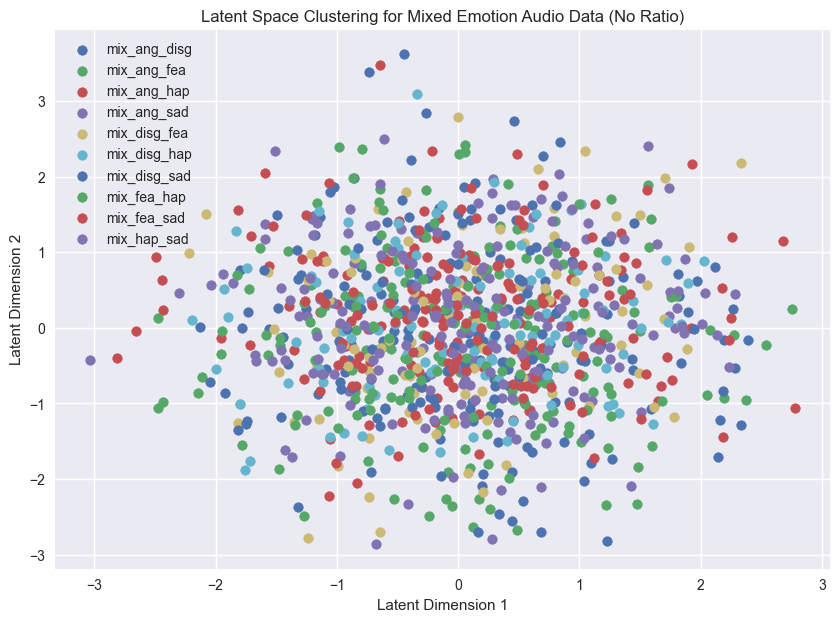

In [13]:
# Extract latent space from the validation dataset
latent_space, labels = extract_latent_space(mix_vae, complete_mix_loader)

# Plot latent space
plt.style.use('seaborn')
plt.figure(figsize=(10, 7))
for label in np.unique(labels):
    plt.scatter(latent_space[labels==label, 0], latent_space[labels==label, 1], label=mix_label_mapping[label])
plt.legend()
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('Latent Space Clustering for Mixed Emotion Audio Data (No Ratio)')
plt.show()

In [14]:
single_train_test_vae = train_test_vae(epochs, single_train_loader, single_val_loader, single_vae, single_optimizer)

Epoch 1, Train Loss: 0.0191
Epoch 1, Val Loss: 0.0072
Epoch 2, Train Loss: 0.0045
Epoch 2, Val Loss: 0.0045
Epoch 3, Train Loss: 0.0030
Epoch 3, Val Loss: 0.0022
Epoch 4, Train Loss: 0.0016
Epoch 4, Val Loss: 0.0017
Epoch 5, Train Loss: 0.0011
Epoch 5, Val Loss: 0.0012
Epoch 6, Train Loss: 0.0010
Epoch 6, Val Loss: 0.0013
Epoch 7, Train Loss: 0.0008
Epoch 7, Val Loss: 0.0011
Epoch 8, Train Loss: 0.0008
Epoch 8, Val Loss: 0.0009
Epoch 9, Train Loss: 0.0008
Epoch 9, Val Loss: 0.0009
Epoch 10, Train Loss: 0.0007
Epoch 10, Val Loss: 0.0009
Epoch 11, Train Loss: 0.0007
Epoch 11, Val Loss: 0.0007
Epoch 12, Train Loss: 0.0006
Epoch 12, Val Loss: 0.0009
Epoch 13, Train Loss: 0.0006
Epoch 13, Val Loss: 0.0010
Epoch 14, Train Loss: 0.0007
Epoch 14, Val Loss: 0.0008
Epoch 15, Train Loss: 0.0007
Epoch 15, Val Loss: 0.0007
Epoch 16, Train Loss: 0.0006
Epoch 16, Val Loss: 0.0008
Epoch 17, Train Loss: 0.0006
Epoch 17, Val Loss: 0.0007
Epoch 18, Train Loss: 0.0007
Epoch 18, Val Loss: 0.0007
Epoch 19, 

/var/folders/h4/3nv1jvkx1yl21fmm86sb8ggh0000gn/T/ipykernel_23646/1093800955.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


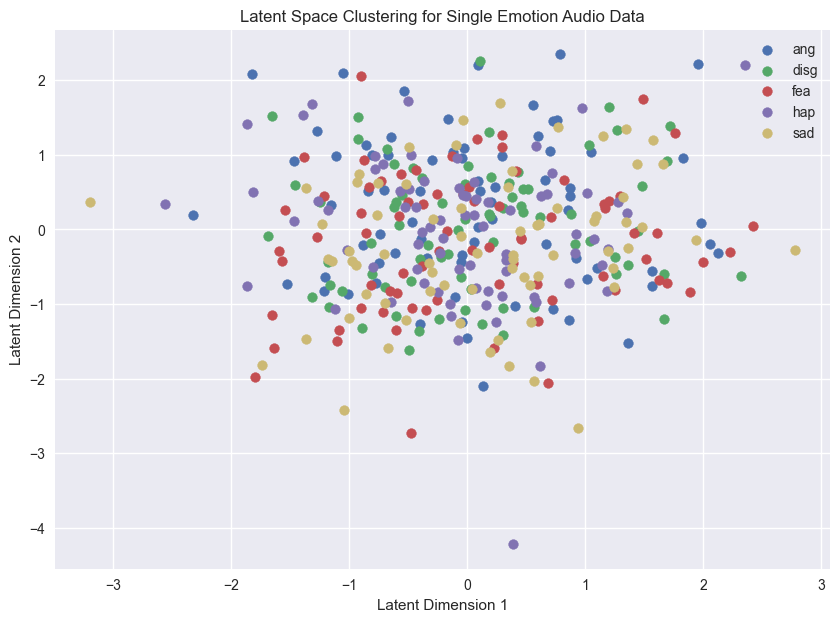

In [15]:
# Extract latent space from the validation dataset
latent_space, labels = extract_latent_space(single_vae, complete_single_loader)

# Plot latent space
plt.style.use('seaborn')
plt.figure(figsize=(10, 7))
for label in np.unique(labels):
    plt.scatter(latent_space[labels==label, 0], latent_space[labels==label, 1], label=single_label_mapping[label])
plt.legend()
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('Latent Space Clustering for Single Emotion Audio Data')
plt.show()